# Feature selection


In [1]:
!git clone https://github.com/tycui/informative_prior.git

Cloning into 'informative_prior'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 35 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), 174.93 KiB | 3.64 MiB/s, done.


In [2]:
import sys
sys.path.insert(0,'/content/informative_prior')

In [3]:
from models.training import *
from models.models_lr import *
import matplotlib.pyplot as plt

In [4]:
def data_generation(A, D, n, sigma, random_seed = 129):
    np.random.seed(random_seed)
    epsilon = np.random.randn(n) * sigma
    X = np.eye(n)
    beta = np.array([A] * D + [0] * (n - D))
    y = beta + epsilon
    return X, y, beta

In [ ]:
D = 20
n = 400
sigma_noise = 2.0
learning_rate = 1*1e-2
batch_size = n
num_epoch = 8000

X, y_10, beta_10 = data_generation(10, D, n, sigma_noise)
x_train = torch.tensor(X, dtype = torch.float);
y_train = torch.tensor(y_10, dtype = torch.float).view(-1,1)

### Feature selection with BetaSS prior

In [ ]:
alpha_b = 2.0; beta_b = 38.0 # p~Beta(2, 38)
alpha_g = .001; beta_g = .001 # \lambda~Inv-Gamma(0.001, 0.001)
sigma = 1. # global scale is 1
lr_ssbg_10 = LR_BetaSS(n, sigma, alpha_b, beta_b, alpha_g, beta_g)
training_lr(lr_ssbg_10, x_train, y_train, learning_rate, batch_size, num_epoch)
beta_posterior_10 = lr_ssbg_10.Layer1.mu_beta.detach().numpy()
lambda_posterior_10 = torch.sigmoid(lr_ssbg_10.Layer1.p_logit).detach().numpy()
prediction_ssbg_10 = beta_posterior_10.reshape(-1) * lambda_posterior_10 * torch.exp(lr_ssbg_10.Layer1.mu_logsigma).detach().numpy()

EPOACH 4000: TRAIN LOSS: 2.2434; KL REG: 2386.2693.
EPOACH 8000: TRAIN LOSS: 2.3191; KL REG: 2318.1616.


### Feature selection with DeltaSS prior

In [ ]:
p = 0.05 # p=0.05
alpha_g = .001; beta_g = .001 # \lambda~Inv-Gamma(0.001, 0.001)
sigma = 1. # global scale is 1
lr_ssg_10 = LR_DeltaSS(n, sigma, p, alpha_g, beta_g)
training_lr(lr_ssg_10, x_train, y_train, learning_rate, batch_size, num_epoch)
beta_posterior_10 = lr_ssg_10.Layer1.mu_beta.detach().numpy()
lambda_posterior_10 = torch.sigmoid(lr_ssg_10.Layer1.p_logit).detach().numpy()
prediction_ssg_10 = beta_posterior_10.reshape(-1) * lambda_posterior_10 * torch.exp(lr_ssg_10.Layer1.mu_logsigma).detach().numpy()

EPOACH 4000: TRAIN LOSS: 2.3273; KL REG: 2382.1328.
EPOACH 8000: TRAIN LOSS: 2.3979; KL REG: 2315.3833.


Feature selection with HS prior

In [ ]:
b_0 = 1.
b_g = D / (n - D) * sigma_noise; b_g = b_g ** 2 # The effective number of features is set to D
lr_hs_10 = LR_HS(n, b_g, b_0)
training_hs_lr(lr_hs_10, x_train, y_train, learning_rate, batch_size, num_epoch)
lr_hs_10.eval(); prediction_hs_10, _ = lr_hs_10(x_train)
prediction_hs_10 = prediction_hs_10.detach().numpy().reshape(-1)

EPOACH 4000: TRAIN LOSS: 1.0873; KL REG: 647.7644.
EPOACH 8000: TRAIN LOSS: 1.1359; KL REG: 637.3081.


Feature selection with InfoSS prior

In [ ]:
k_min = 0.; k_max = 30.; tau = 5. # m~U[0,30]
alpha_g = 0.001; beta_g = 0.001 # \lambda~Inv-Gamma(0.001, 0.001)
sigma = 1. # global scale is 1
lr_infossg_10 = LR_InfoSS(n, sigma,  alpha_g, beta_g,  k_min, k_max, tau)
training_lr(lr_infossg_10, x_train, y_train, learning_rate, batch_size, num_epoch)
beta_posterior_10 = lr_infossg_10.Layer1.mu_beta.detach().numpy()
lambda_posterior_10 = torch.sigmoid(lr_infossg_10.Layer1.p_logit).detach().numpy()
prediction_infossg_10 = beta_posterior_10.reshape(-1) * lambda_posterior_10 * torch.exp(lr_infossg_10.Layer1.mu_logsigma).detach().numpy()

EPOACH 4000: TRAIN LOSS: 3.0428; KL REG: 2263.6541.
EPOACH 8000: TRAIN LOSS: 3.0593; KL REG: 2162.7253.


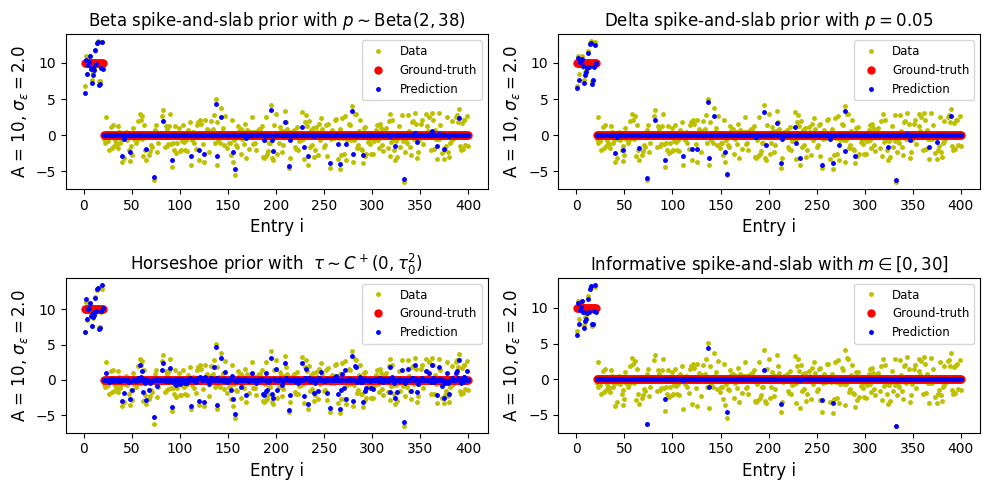

In [ ]:
x_axis = np.linspace(1, n, n);  font_size_title = 12

fig_l, axes_l = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 5))
ax_00, ax_01, ax_10, ax_11 = axes_l.flatten()

ax_00.plot(x_axis, y_10, 'y.', markersize=5)
ax_00.plot(x_axis, beta_10, 'r.', markersize=10)
ax_00.plot(x_axis, prediction_ssbg_10, 'b.', markersize=5)
ax_00.legend(['Data', 'Ground-truth', 'Prediction'], fontsize = 8.5)
ax_00.set_xlabel('Entry i', fontsize = font_size_title)
ax_00.set_ylabel(r'A = 10, $\sigma_\epsilon = 2.0$', fontsize = font_size_title)
ax_00.set_title(r'Beta spike-and-slab prior with $p \sim $Beta$(2, 38)$', fontsize = font_size_title) 

ax_01.plot(x_axis, y_10, 'y.', markersize=5)
ax_01.plot(x_axis, beta_10, 'r.', markersize=10)
ax_01.plot(x_axis, prediction_ssg_10, 'b.', markersize=5)
ax_01.legend(['Data', 'Ground-truth', 'Prediction'], fontsize = 8.5)
ax_01.set_xlabel('Entry i', fontsize = font_size_title)
ax_01.set_ylabel(r'A = 10, $\sigma_\epsilon = 2.0$', fontsize = font_size_title)
ax_01.set_title(r'Delta spike-and-slab prior with $p = 0.05$', fontsize = font_size_title) 

ax_10.plot(x_axis, y_10, 'y.', markersize=5)
ax_10.plot(x_axis, beta_10, 'r.', markersize=10)
ax_10.plot(x_axis, prediction_hs_10, 'b.', markersize=5)
ax_10.legend(['Data', 'Ground-truth', 'Prediction'], fontsize = 8.5)
ax_10.set_xlabel('Entry i', fontsize = font_size_title)
ax_10.set_ylabel(r'A = 10, $\sigma_\epsilon = 2.0$', fontsize = font_size_title)
ax_10.set_title(r'Horseshoe prior with  $\tau \sim C^+(0, \tau_0^2)$', fontsize = font_size_title) 

ax_11.plot(x_axis, y_10, 'y.', markersize=5)
ax_11.plot(x_axis, beta_10, 'r.', markersize=10)
ax_11.plot(x_axis, prediction_infossg_10, 'b.', markersize=5)
ax_11.legend(['Data', 'Ground-truth', 'Prediction'], fontsize = 8.5)
ax_11.set_xlabel('Entry i', fontsize = font_size_title)
ax_11.set_ylabel(r'A = 10, $\sigma_\epsilon = 2.0$', fontsize = font_size_title)
ax_11.set_title(r'Informative spike-and-slab with $m \in [0, 30]$', fontsize = font_size_title)  

fig_l.tight_layout()

# Learning PVE

In [4]:
from models.stein import *
from models.pve import *
import torch.optim as optim
from data.data_generation import *
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [ ]:
def plot_empirical(samples, prior):
    # dataset
    X = samples.detach().numpy().reshape(-1)
    X_plot = np.linspace(min(X), max(X), 1000)
    num_bins = 35
    fig, ax = plt.subplots()
    # the histogram of the data
    n, bins, patches = ax.hist(X, num_bins, density=1)

    ax.set_xlabel('PVE')
    ax.set_ylabel('density')

    kde = gaussian_kde(X)
    kde_pdf = kde.evaluate(X_plot)

    prior_pdf = prior.pdf(torch.tensor(X_plot)).numpy()
    ax.plot(X_plot, kde_pdf)
    ax.plot(X_plot, prior_pdf, 'r-')
    ax.set_title('Empirical distribution of PVE')

    ax.legend(('KDE of empirical PVE', 'Prior PVE', 'Empirical PVE'))

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.show()

# 1 Load the data

In [ ]:
path_data = '/content/informative_prior/data/'
num_random = 0; noise_level = 0.
x, y, x_test, y_test, num_useful, num_feature = data_generating_energy(path_data, num_random, noise_level)

# 2 Learning the scale parameter of Inv-Gamma

In [ ]:
alpha_prior = 5.0; beta_prior = 1.0; prior = BetaPrior(alpha_prior, beta_prior)  # prior pve: Beta(5,1)
eta = 0.1; estimator = SteinGradientEstimator(eta)  # define the stein gradient estimator
learning_rate = 2 * 1e-3;  M = 300 # define learning rate and batch size (M)
num_hidden_nodes = [50, 30] # define the NN architecture
sampler = PVESampler_ARD(x, M, num_hidden_nodes)  # define the sampler of implicity distribution

# 2.1 Empirical model PVE before stein gradient optimization

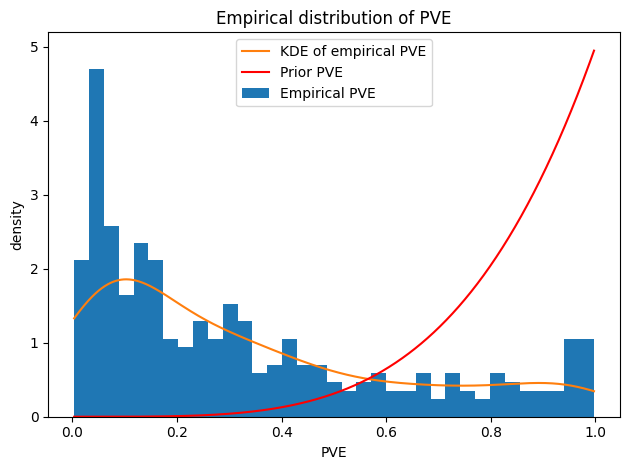

In [ ]:
samples = sampler()
plot_empirical(samples, prior)

# 2.2 Stein gradient optimization

In [ ]:
parameters = sampler.parameters()
optimizer = optim.SGD(parameters, lr=learning_rate)
num_epoch = 200;
minimize_kldivergence(sampler, prior, optimizer, estimator, num_epoch)

EPOCH 0: KL: 4.2476.
EPOCH 10: KL: 1.2279.
EPOCH 20: KL: -0.2667.
EPOCH 30: KL: -0.9793.
EPOCH 40: KL: -1.1820.
EPOCH 50: KL: -1.2879.
EPOCH 60: KL: -1.4338.
EPOCH 70: KL: -1.5300.
EPOCH 80: KL: -1.4484.
EPOCH 90: KL: -1.5351.
EPOCH 100: KL: -1.6109.
EPOCH 110: KL: -1.4749.
EPOCH 120: KL: -1.6433.
EPOCH 130: KL: -1.6829.
EPOCH 140: KL: -1.5658.
EPOCH 150: KL: -1.5738.
EPOCH 160: KL: -1.7362.
EPOCH 170: KL: -1.5582.
EPOCH 180: KL: -1.5660.
EPOCH 190: KL: -1.5870.


array([0.38418677], dtype=float32)

# 2.3 Empirical model PVE after stein gradient optimization

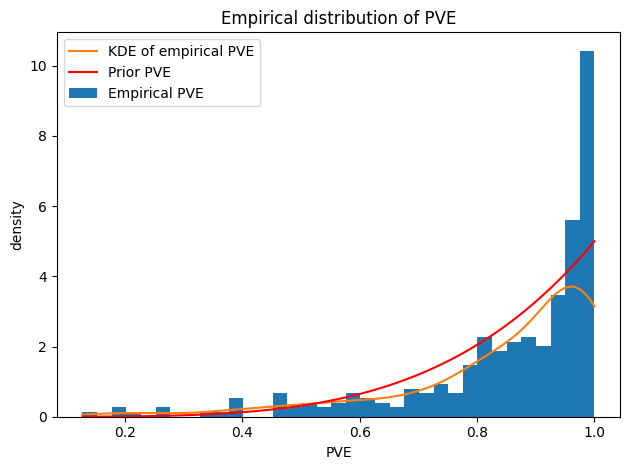

In [ ]:
samples = sampler()
plot_empirical(samples, prior)

# 3 Learning the scale parameter of Gaussian

In [ ]:
alpha_prior = 5.0; beta_prior = 1.0; prior = BetaPrior(alpha_prior, beta_prior)  # prior pve: Beta(5,1)
eta = 0.1; estimator = SteinGradientEstimator(eta)  # define the stein gradient estimator
learning_rate = 2 * 1e-3;  M = 300 # define learning rate and batch size (M)
num_hidden_nodes = [50, 30] # define the NN architecture
sampler = PVESampler_Gaussian(x, M, num_hidden_nodes)  # define the sampler of implicity distribution

# 3.1 Empirical model PVE before stein gradient optimization

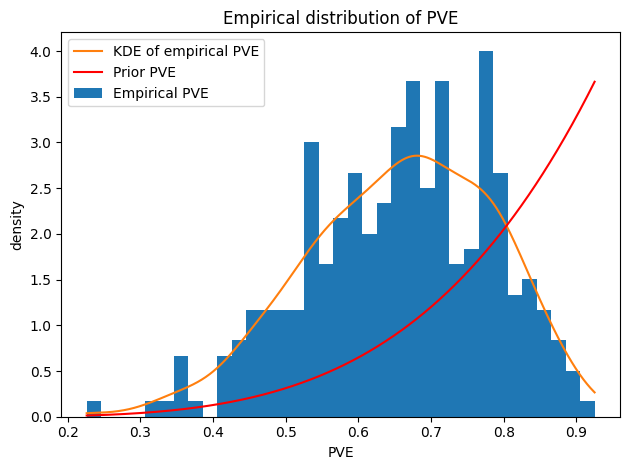

In [ ]:
samples = sampler()
plot_empirical(samples, prior)

# 3.2 Stein gradient optimization

In [ ]:
parameters = sampler.parameters()
optimizer = optim.SGD(parameters, lr=learning_rate)
num_epoch = 200;
minimize_kldivergence(sampler, prior, optimizer, estimator, num_epoch)

EPOCH 0: KL: -0.8394.
EPOCH 10: KL: -1.1577.
EPOCH 20: KL: -1.3205.
EPOCH 30: KL: -1.3656.
EPOCH 40: KL: -1.4812.
EPOCH 50: KL: -1.5380.
EPOCH 60: KL: -1.5646.
EPOCH 70: KL: -1.6425.
EPOCH 80: KL: -1.6800.
EPOCH 90: KL: -1.7239.
EPOCH 100: KL: -1.7328.
EPOCH 110: KL: -1.7266.
EPOCH 120: KL: -1.7673.
EPOCH 130: KL: -1.7512.
EPOCH 140: KL: -1.7824.
EPOCH 150: KL: -1.8372.
EPOCH 160: KL: -1.8282.
EPOCH 170: KL: -1.7566.
EPOCH 180: KL: -1.7402.
EPOCH 190: KL: -1.8562.


array([0.47411957], dtype=float32)

# 3.3 Empirical model PVE after stein gradient optimization

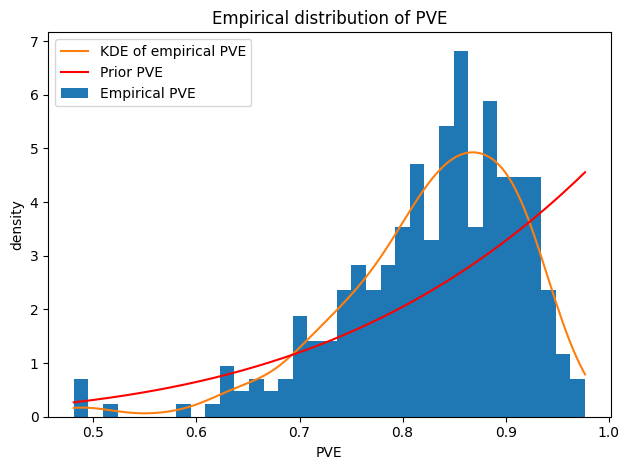

In [ ]:
samples = sampler()
plot_empirical(samples, prior)

# BNN

In [5]:
import os
from models.training import *
from data.data_generation import *
from models.models_nn import *
from models.stein import *
from models.pve import *
import torch.optim as optim
from data.data_generation import *
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [ ]:
def plot_empirical(samples, prior):
    # dataset
    X = samples.detach().numpy().reshape(-1)
    X_plot = np.linspace(min(X), max(X), 1000)
    num_bins = 35
    fig, ax = plt.subplots()
    # the histogram of the data
    n, bins, patches = ax.hist(X, num_bins, density=1)

    ax.set_xlabel('PVE')
    ax.set_ylabel('density')

    kde = gaussian_kde(X)
    kde_pdf = kde.evaluate(X_plot)

    prior_pdf = prior.pdf(torch.tensor(X_plot)).numpy()
    ax.plot(X_plot, kde_pdf)
    ax.plot(X_plot, prior_pdf, 'r-')
    ax.set_title('Empirical distribution of PVE')

    ax.legend(('KDE of empirical PVE', 'Prior PVE', 'Empirical PVE'))

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.show()

In [ ]:
path_data = os.getcwd() + '/informative_prior/data/'
########### Training Hyperparameters
num_hidden_nodes = [50, 30]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 2*1e-3
batch_size = 100
###########
num_random = 100; noise_level = 0.8
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_energy(path_data, num_random, noise_level)

# HMF prior with information of PVE and sparsity

# step 1. define prior belief about the number of relevant features

In [6]:
k_min = 0.; k_max = num_useful; tau = np.exp(2);

NameError: ignored

# step 2. learn the optimal scale parameter to match prior PVE

In [ ]:
def learn_optimal_pve():
    alpha_prior = 1.5; beta_prior = 3.0; prior = BetaPrior(alpha_prior, beta_prior)  # prior pve: Beta(1.5,3)
    eta = 0.1; estimator = SteinGradientEstimator(eta)  # define the stein gradient estimator
    learning_rate = 2 * 1e-3;  M = 300 # define learning rate and batch size (M)
    num_hidden_nodes = [50, 30] # define the NN architecture
    sampler = PVESampler_InfoARD(x, M, num_hidden_nodes, k_min, k_max, tau)  # define the sampler of implicity distribution
    samples = sampler()
    plot_empirical(samples, prior)
    parameters = sampler.parameters()
    optimizer = optim.SGD(parameters, lr=learning_rate)
    num_epoch_stein = 200;
    scale = minimize_kldivergence(sampler, prior, optimizer, estimator, num_epoch_stein)
    samples = sampler()
    plot_empirical(samples, prior)
    return scale

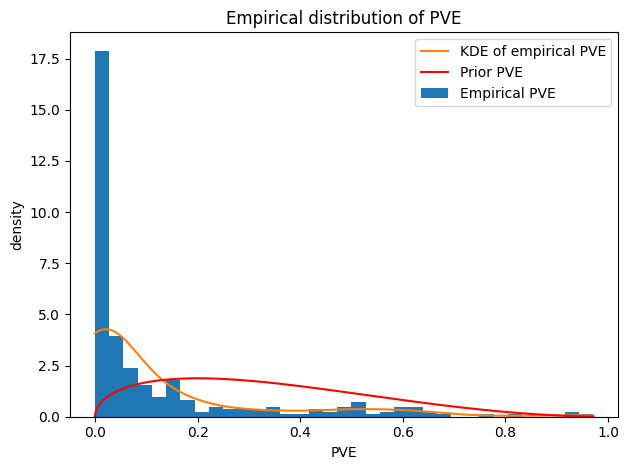

EPOCH 0: KL: -0.1593.
EPOCH 10: KL: 0.0208.
EPOCH 20: KL: 0.3564.
EPOCH 30: KL: 0.2308.
EPOCH 40: KL: 0.0333.
EPOCH 50: KL: 0.0116.
EPOCH 60: KL: 0.1235.
EPOCH 70: KL: 0.0385.
EPOCH 80: KL: 0.0665.
EPOCH 90: KL: 0.1415.
EPOCH 100: KL: 0.3033.
EPOCH 110: KL: -0.1872.
EPOCH 120: KL: 0.2693.
EPOCH 130: KL: 0.0838.
EPOCH 140: KL: 0.0273.
EPOCH 150: KL: 0.5096.
EPOCH 160: KL: 0.2588.
EPOCH 170: KL: 0.4371.
EPOCH 180: KL: -0.0285.
EPOCH 190: KL: -0.0312.


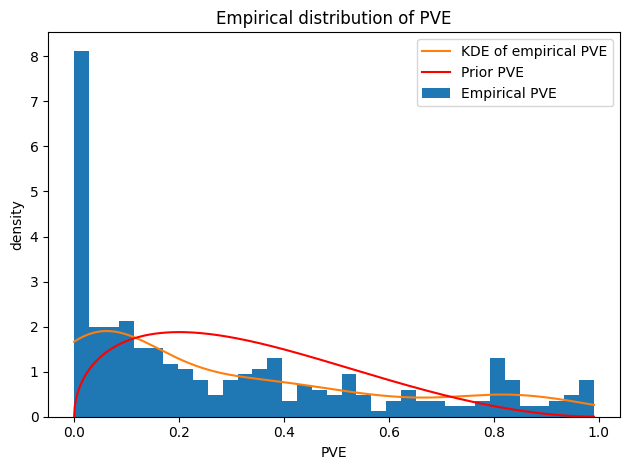

In [ ]:
scale = learn_optimal_pve()

In [ ]:
print('optimal scale is ' + str(scale))

optimal scale is [0.20270972]


# step 3. train BNNs with information of sparsity and PVE

Informative Hierarchical meanfield PVE BNN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

EPOACH 1: TRAIN LOSS: 3.1860; KL REG: 19291.0176; TEST LOSS IS: 3.35785.
EPOACH 501: TRAIN LOSS: 0.8304; KL REG: 2418.3599; TEST LOSS IS: 0.88701.
EPOACH 1001: TRAIN LOSS: 0.8756; KL REG: 328.4596; TEST LOSS IS: 0.84691.
EPOACH 1501: TRAIN LOSS: 0.8748; KL REG: 134.2346; TEST LOSS IS: 0.84400.
EPOACH 2001: TRAIN LOSS: 0.8633; KL REG: 84.5429; TEST LOSS IS: 0.83677.
EPOACH 2501: TRAIN LOSS: 0.8586; KL REG: 85.2879; TEST LOSS IS: 0.83650.
EPOACH 3001: TRAIN LOSS: 0.8584; KL REG: 77.3526; TEST LOSS IS: 0.83596.
EPOACH 3501: TRAIN LOSS: 0.8564; KL REG: 81.2244; TEST LOSS IS: 0.83550.
EPOACH 4001: TRAIN LOSS: 0.8556; KL REG: 73.3531; TEST LOSS IS: 0.83568.
EPOACH 4501: TRAIN LOSS: 0.8553; KL REG: 69.9928; TEST LOSS IS: 0.83615.


In [ ]:
np.mean(PVE_test_noise(ihmf_pve, x_test, y_test))

0.11989086866378784

In [ ]:
print("train error : ", training_error_ihmf_pve[-1])
print("test error : ", test_error_ihmf_pve[-1])

train error :  tensor(0.8561)
test error :  tensor(0.8384)


Hierarchical Meanfield NN


In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

EPOACH 1: TRAIN LOSS: 5.9116; KL REG: 18703.4160; TEST LOSS IS: 5.20784.
EPOACH 501: TRAIN LOSS: 0.7135; KL REG: 2471.3892; TEST LOSS IS: 0.86740.
EPOACH 1001: TRAIN LOSS: 0.8288; KL REG: 200.5015; TEST LOSS IS: 0.85492.
EPOACH 1501: TRAIN LOSS: 0.8323; KL REG: 124.0180; TEST LOSS IS: 0.84627.
EPOACH 2001: TRAIN LOSS: 0.8287; KL REG: 114.0650; TEST LOSS IS: 0.84503.
EPOACH 2501: TRAIN LOSS: 0.8269; KL REG: 110.5474; TEST LOSS IS: 0.84564.
EPOACH 3001: TRAIN LOSS: 0.8267; KL REG: 107.6494; TEST LOSS IS: 0.85477.
EPOACH 3501: TRAIN LOSS: 0.8331; KL REG: 106.0896; TEST LOSS IS: 0.84424.
EPOACH 4001: TRAIN LOSS: 0.8277; KL REG: 105.3168; TEST LOSS IS: 0.85036.
EPOACH 4501: TRAIN LOSS: 0.8269; KL REG: 106.1727; TEST LOSS IS: 0.84632.


In [ ]:
np.mean(PVE_test_noise(hmf, x_test, y_test))

0.11391407251358032

In [ ]:
print("train error : ", training_error_hmf[-1])
print("test error : ", test_error_hmf[-1])

train error :  tensor(0.8258)
test error :  tensor(0.8527)


Informative Hiericical Meanfield Gaussian BNN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

EPOACH 1: TRAIN LOSS: 1.2703; KL REG: 19034.5898; TEST LOSS IS: 1.23429.
EPOACH 501: TRAIN LOSS: 0.7286; KL REG: 2092.6323; TEST LOSS IS: 0.71332.
EPOACH 1001: TRAIN LOSS: 0.8250; KL REG: 207.8772; TEST LOSS IS: 0.68390.
EPOACH 1501: TRAIN LOSS: 0.8354; KL REG: 109.9130; TEST LOSS IS: 0.69112.
EPOACH 2001: TRAIN LOSS: 0.8271; KL REG: 108.5291; TEST LOSS IS: 0.68821.
EPOACH 2501: TRAIN LOSS: 0.8278; KL REG: 96.5502; TEST LOSS IS: 0.68705.
EPOACH 3001: TRAIN LOSS: 0.8206; KL REG: 88.7205; TEST LOSS IS: 0.68370.
EPOACH 3501: TRAIN LOSS: 0.8184; KL REG: 87.8054; TEST LOSS IS: 0.68215.
EPOACH 4001: TRAIN LOSS: 0.8149; KL REG: 94.8932; TEST LOSS IS: 0.68173.
EPOACH 4501: TRAIN LOSS: 0.8190; KL REG: 78.6194; TEST LOSS IS: 0.68051.


In [ ]:
np.mean(PVE_test_noise(ihmf, x_test, y_test))

0.18941009044647217

In [ ]:
print("train error : ", training_error_ihmf[-1])
print("test error : ", test_error_ihmf[-1])

train error :  tensor(0.8140)
test error :  tensor(0.6813)


Hiericical Meanfield Gaussian BNN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

EPOACH 1: TRAIN LOSS: 3.1379; KL REG: 18663.8633; TEST LOSS IS: 2.90064.
EPOACH 501: TRAIN LOSS: 0.7187; KL REG: 2305.6479; TEST LOSS IS: 0.87162.
EPOACH 1001: TRAIN LOSS: 0.8749; KL REG: 172.2672; TEST LOSS IS: 0.85639.
EPOACH 1501: TRAIN LOSS: 0.8690; KL REG: 122.2337; TEST LOSS IS: 0.84771.
EPOACH 2001: TRAIN LOSS: 0.8466; KL REG: 113.0295; TEST LOSS IS: 0.84038.
EPOACH 2501: TRAIN LOSS: 0.8402; KL REG: 109.0744; TEST LOSS IS: 0.84047.
EPOACH 3001: TRAIN LOSS: 0.8326; KL REG: 109.0820; TEST LOSS IS: 0.83865.
EPOACH 3501: TRAIN LOSS: 0.8293; KL REG: 108.8138; TEST LOSS IS: 0.84327.
EPOACH 4001: TRAIN LOSS: 0.8301; KL REG: 107.9398; TEST LOSS IS: 0.83977.
EPOACH 4501: TRAIN LOSS: 0.8274; KL REG: 108.2946; TEST LOSS IS: 0.83931.


In [ ]:
np.mean(PVE_test_noise(hmf_pve, x_test, y_test))

0.1150742769241333

In [ ]:
print("train error : ", training_error_hmf_pve[-1])
print("test error : ", test_error_hmf_pve[-1])

train error :  tensor(0.8372)
test error :  tensor(0.8410)


# Sans bruit et juste avec les relevant features


In [ ]:
path_data = os.getcwd() + '/informative_prior/data/'
########### Training Hyperparameters
num_hidden_nodes = [50, 30]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 2*1e-3
batch_size = 100
###########
num_random = 0; noise_level = 0
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_energy(path_data, num_random, noise_level)

In [ ]:
k_min = 0.; k_max = num_useful; tau = np.exp(2);

Informative Hierarchical Meanfield PVE BNN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

EPOACH 1: TRAIN LOSS: 1.2504; KL REG: 5577.4375; TEST LOSS IS: 1.27183.
EPOACH 501: TRAIN LOSS: 0.0709; KL REG: 1118.4399; TEST LOSS IS: 0.07341.
EPOACH 1001: TRAIN LOSS: 0.0621; KL REG: 489.9937; TEST LOSS IS: 0.06151.
EPOACH 1501: TRAIN LOSS: 0.0519; KL REG: 356.6237; TEST LOSS IS: 0.05476.
EPOACH 2001: TRAIN LOSS: 0.0469; KL REG: 322.3710; TEST LOSS IS: 0.05060.
EPOACH 2501: TRAIN LOSS: 0.0448; KL REG: 308.3958; TEST LOSS IS: 0.04886.
EPOACH 3001: TRAIN LOSS: 0.0440; KL REG: 300.1021; TEST LOSS IS: 0.04859.
EPOACH 3501: TRAIN LOSS: 0.0434; KL REG: 286.9951; TEST LOSS IS: 0.04856.
EPOACH 4001: TRAIN LOSS: 0.0427; KL REG: 281.7816; TEST LOSS IS: 0.04759.
EPOACH 4501: TRAIN LOSS: 0.0440; KL REG: 272.7238; TEST LOSS IS: 0.04765.


In [ ]:
np.mean(PVE_test_noise(ihmf_pve, x_test, y_test))

0.9546631574630737

In [ ]:
print("train error : ", training_error_ihmf_pve[-1])
print("test error : ", test_error_ihmf_pve[-1])

train error :  tensor(0.0422)
test error :  tensor(0.0466)


Hierarchical Meanfield NN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

EPOACH 1: TRAIN LOSS: 0.4245; KL REG: 5582.3564; TEST LOSS IS: 0.43208.
EPOACH 501: TRAIN LOSS: 0.0831; KL REG: 801.2305; TEST LOSS IS: 0.08922.
EPOACH 1001: TRAIN LOSS: 0.0683; KL REG: 377.2559; TEST LOSS IS: 0.06879.
EPOACH 1501: TRAIN LOSS: 0.0614; KL REG: 326.5374; TEST LOSS IS: 0.06093.
EPOACH 2001: TRAIN LOSS: 0.0535; KL REG: 301.1777; TEST LOSS IS: 0.05572.
EPOACH 2501: TRAIN LOSS: 0.0421; KL REG: 299.5665; TEST LOSS IS: 0.04862.
EPOACH 3001: TRAIN LOSS: 0.0360; KL REG: 304.1052; TEST LOSS IS: 0.04357.
EPOACH 3501: TRAIN LOSS: 0.0310; KL REG: 302.5777; TEST LOSS IS: 0.03699.
EPOACH 4001: TRAIN LOSS: 0.0303; KL REG: 296.3990; TEST LOSS IS: 0.03519.
EPOACH 4501: TRAIN LOSS: 0.0302; KL REG: 297.6909; TEST LOSS IS: 0.03509.


In [ ]:
np.mean(PVE_test_noise(hmf, x_test, y_test))

0.9655869603157043

In [ ]:
print("train error : ", training_error_hmf[-1])
print("test error : ", test_error_hmf[-1])

train error :  tensor(0.0294)
test error :  tensor(0.0355)


Informative Hiericical Meanfield Gaussian BNN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

EPOACH 1: TRAIN LOSS: 0.7147; KL REG: 5531.4741; TEST LOSS IS: 0.63555.
EPOACH 501: TRAIN LOSS: 0.0877; KL REG: 788.0942; TEST LOSS IS: 0.09396.
EPOACH 1001: TRAIN LOSS: 0.0667; KL REG: 333.6970; TEST LOSS IS: 0.07558.
EPOACH 1501: TRAIN LOSS: 0.0557; KL REG: 276.6728; TEST LOSS IS: 0.06069.
EPOACH 2001: TRAIN LOSS: 0.0488; KL REG: 261.5927; TEST LOSS IS: 0.05364.
EPOACH 2501: TRAIN LOSS: 0.0471; KL REG: 257.1435; TEST LOSS IS: 0.05455.
EPOACH 3001: TRAIN LOSS: 0.0438; KL REG: 255.3905; TEST LOSS IS: 0.04802.
EPOACH 3501: TRAIN LOSS: 0.0435; KL REG: 258.8772; TEST LOSS IS: 0.04698.
EPOACH 4001: TRAIN LOSS: 0.0431; KL REG: 255.1770; TEST LOSS IS: 0.04510.
EPOACH 4501: TRAIN LOSS: 0.0422; KL REG: 253.1655; TEST LOSS IS: 0.04717.


In [ ]:
np.mean(PVE_test_noise(ihmf, x_test, y_test))

0.9550902247428894

In [ ]:
print("train error : ", training_error_ihmf[-1])
print("test error : ", test_error_ihmf[-1])

train error :  tensor(0.0418)
test error :  tensor(0.0460)


Hiericical Meanfield Gaussian BNN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

EPOACH 1: TRAIN LOSS: 1.0930; KL REG: 5583.8555; TEST LOSS IS: 1.08751.
EPOACH 501: TRAIN LOSS: 0.0572; KL REG: 1121.6929; TEST LOSS IS: 0.06550.
EPOACH 1001: TRAIN LOSS: 0.0520; KL REG: 546.2390; TEST LOSS IS: 0.05532.
EPOACH 1501: TRAIN LOSS: 0.0462; KL REG: 449.3002; TEST LOSS IS: 0.05187.
EPOACH 2001: TRAIN LOSS: 0.0363; KL REG: 409.2827; TEST LOSS IS: 0.04172.
EPOACH 2501: TRAIN LOSS: 0.0347; KL REG: 387.1328; TEST LOSS IS: 0.04043.
EPOACH 3001: TRAIN LOSS: 0.0340; KL REG: 365.4413; TEST LOSS IS: 0.03980.
EPOACH 3501: TRAIN LOSS: 0.0324; KL REG: 342.5883; TEST LOSS IS: 0.03937.
EPOACH 4001: TRAIN LOSS: 0.0319; KL REG: 326.2624; TEST LOSS IS: 0.03882.
EPOACH 4501: TRAIN LOSS: 0.0315; KL REG: 319.9324; TEST LOSS IS: 0.03998.


In [ ]:
np.mean(PVE_test_noise(hmf_pve, x_test, y_test))

0.9626717567443848

In [ ]:
print("train error : ", training_error_hmf_pve[-1])
print("test error : ", test_error_hmf_pve[-1])

train error :  tensor(0.0314)
test error :  tensor(0.0382)


recap pour dataset energy: 

|prior       |  test error sans bruit    |    test error avec bruit |
|------------|----------------|---------------|
|HMF         |   0.0355       |      0.8527   |
|HMF + PVE   |   0.0382       |      0.8410   |
|IHMF        |   0.0460       |      0.6813   |
|IHMF + PVE  |   0.0466       |      0.8384   | 

# Concrete dataset


In [7]:
from sklearn import preprocessing
import torch
import numpy as np
import pandas as pd

def data_generating_concrete(data_path, num_random, noise_level):
    df = pd.read_csv(data_path + "Concrete_Data.csv", sep=",")
    # df = df.drop(['Unnamed: 10','Unnamed: 11','Y1'], axis = 1)
    df = df.dropna(axis=0)
    np.random.seed(129)
    msk_1 = np.random.rand(len(df)) < 0.8
    traindf = df[msk_1]
    testdf = df[~msk_1]
    # training set
    trainx = traindf.drop('Concrete compressive strength(MPa, megapascals) ', axis=1).values
    trainy = traindf['Concrete compressive strength(MPa, megapascals) '].values
    # test set
    testx = testdf.drop('Concrete compressive strength(MPa, megapascals) ', axis=1).values
    testy = testdf['Concrete compressive strength(MPa, megapascals) '].values

    # le csv est rempli comme de la merde
    for i in range(len(trainx)):
      for j in range(len(trainx[0])):
        if type(trainx[i][j]) == str:
          trainx[i][j] = trainx[i][j].replace(",", ".")
          if trainx[i][j][-1].isspace():
              trainx[i][j] = trainx[i][j][:-1]

      if type(trainy[i]) == str:
          trainy[i] = trainy[i].replace(",", ".")
          if trainy[i][-1].isspace():
              trainy[i] = trainy[i][:-1]

    for i in range(len(testx)):
      for j in range(len(testx[0])):
        if type(testx[i][j]) == str:
          testx[i][j] = testx[i][j].replace(",", ".")
          if testx[i][j][-1].isspace():
              testx[i][j] = testx[i][j][:-1]

      if type(testy[i]) == str:
          testy[i] = testy[i].replace(",", ".")
          if testy[i][-1].isspace():
              testy[i] = testy[i][:-1]

    scalerx = preprocessing.StandardScaler().fit(trainx)
    trainx = scalerx.transform(trainx)
    testx = scalerx.transform(testx)

    scalery = preprocessing.StandardScaler().fit(trainy.reshape(-1,1))
    trainy = scalery.transform(trainy.reshape(-1,1)).reshape(1, -1)
    testy = scalery.transform(testy.reshape(-1,1)).reshape(1, -1)
    
    # transfer data into tensor
    x = torch.tensor(trainx, dtype = torch.float)
    y = torch.tensor(trainy[0], dtype = torch.float).view(-1,1)
    x_test = torch.tensor(testx, dtype = torch.float)
    y_test = torch.tensor(testy[0], dtype = torch.float).view(-1,1)
    
    if num_random != 0:
        rand_features = torch.randn(x.shape[0], num_random) * 2
        x = torch.cat((x, rand_features), 1)
        rand_features = torch.randn(x_test.shape[0], num_random) *2
        x_test = torch.cat((x_test, rand_features), 1)
    
    if noise_level != 0:
        noise = torch.randn_like(y) * np.sqrt(noise_level); noise_test = torch.randn_like(y_test) * np.sqrt(noise_level)
        y = y * np.sqrt(1-noise_level) + noise; y_test = y_test * np.sqrt(1-noise_level) + noise_test;     
        
    num_useful = 9.; num_feature = x.shape[1]

    return x, y, x_test, y_test, num_useful, num_feature

# sans bruit

In [ ]:
path_data = os.getcwd() + '/informative_prior/data/'
########### Training Hyperparameters
num_hidden_nodes = [50, 30]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 2*1e-3
batch_size = 100
###########
num_random = 0; noise_level = 0
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_concrete(path_data, num_random, noise_level)

In [ ]:
k_min = 0.; k_max = num_useful; tau = np.exp(2);

Informative Hierarchical Meanfield PVE BNN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(ihmf_pve, x_test, y_test))

print("train error : ", training_error_ihmf_pve[-1])
print("test error : ", test_error_ihmf_pve[-1])

EPOACH 1: TRAIN LOSS: 0.6259; KL REG: 5553.9492; TEST LOSS IS: 0.77853.
EPOACH 501: TRAIN LOSS: 0.1523; KL REG: 921.3653; TEST LOSS IS: 0.16523.
EPOACH 1001: TRAIN LOSS: 0.1377; KL REG: 413.2061; TEST LOSS IS: 0.14559.
EPOACH 1501: TRAIN LOSS: 0.1261; KL REG: 343.7479; TEST LOSS IS: 0.13342.
EPOACH 2001: TRAIN LOSS: 0.1216; KL REG: 333.6635; TEST LOSS IS: 0.13484.
EPOACH 2501: TRAIN LOSS: 0.1134; KL REG: 337.2020; TEST LOSS IS: 0.13094.
EPOACH 3001: TRAIN LOSS: 0.1094; KL REG: 336.5364; TEST LOSS IS: 0.12984.
EPOACH 3501: TRAIN LOSS: 0.1075; KL REG: 338.5259; TEST LOSS IS: 0.12977.
EPOACH 4001: TRAIN LOSS: 0.1058; KL REG: 339.7736; TEST LOSS IS: 0.13039.
EPOACH 4501: TRAIN LOSS: 0.1055; KL REG: 343.6198; TEST LOSS IS: 0.12989.
train error :  tensor(0.1049)
test error :  tensor(0.1322)


Hierarchical meanfield BNN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(hmf, x_test, y_test))

print("train error : ", training_error_hmf[-1])
print("test error : ", test_error_hmf[-1])

EPOACH 1: TRAIN LOSS: 2.1271; KL REG: 5579.5781; TEST LOSS IS: 2.12023.
EPOACH 501: TRAIN LOSS: 0.1395; KL REG: 839.1862; TEST LOSS IS: 0.14916.
EPOACH 1001: TRAIN LOSS: 0.1266; KL REG: 421.2988; TEST LOSS IS: 0.13907.
EPOACH 1501: TRAIN LOSS: 0.1174; KL REG: 357.2134; TEST LOSS IS: 0.12886.
EPOACH 2001: TRAIN LOSS: 0.1148; KL REG: 326.6478; TEST LOSS IS: 0.12789.
EPOACH 2501: TRAIN LOSS: 0.1113; KL REG: 317.5149; TEST LOSS IS: 0.12539.
EPOACH 3001: TRAIN LOSS: 0.1076; KL REG: 323.8122; TEST LOSS IS: 0.12310.
EPOACH 3501: TRAIN LOSS: 0.1051; KL REG: 328.0672; TEST LOSS IS: 0.12293.
EPOACH 4001: TRAIN LOSS: 0.1044; KL REG: 332.0158; TEST LOSS IS: 0.12635.
EPOACH 4501: TRAIN LOSS: 0.1026; KL REG: 335.1297; TEST LOSS IS: 0.12122.
train error :  tensor(0.1017)
test error :  tensor(0.1220)


Informative Hierarchical meanfield BNN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(ihmf, x_test, y_test))

print("train error : ", training_error_ihmf[-1])
print("test error : ", test_error_ihmf[-1])

EPOACH 1: TRAIN LOSS: 2.8328; KL REG: 5567.3213; TEST LOSS IS: 2.89111.
EPOACH 501: TRAIN LOSS: 0.1775; KL REG: 850.8842; TEST LOSS IS: 0.18662.
EPOACH 1001: TRAIN LOSS: 0.1688; KL REG: 334.2643; TEST LOSS IS: 0.16942.
EPOACH 1501: TRAIN LOSS: 0.1691; KL REG: 262.8865; TEST LOSS IS: 0.16845.
EPOACH 2001: TRAIN LOSS: 0.1592; KL REG: 239.9909; TEST LOSS IS: 0.15567.
EPOACH 2501: TRAIN LOSS: 0.1534; KL REG: 239.1198; TEST LOSS IS: 0.15081.
EPOACH 3001: TRAIN LOSS: 0.1489; KL REG: 244.1465; TEST LOSS IS: 0.14732.
EPOACH 3501: TRAIN LOSS: 0.1453; KL REG: 243.1783; TEST LOSS IS: 0.14386.
EPOACH 4001: TRAIN LOSS: 0.1483; KL REG: 245.9147; TEST LOSS IS: 0.14930.
EPOACH 4501: TRAIN LOSS: 0.1428; KL REG: 248.7831; TEST LOSS IS: 0.14184.
train error :  tensor(0.1417)
test error :  tensor(0.1432)


Hierarchical Meanfield PVE BNN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(hmf_pve, x_test, y_test))

print("train error : ", training_error_hmf_pve[-1])
print("test error : ", test_error_hmf_pve[-1])

EPOACH 1: TRAIN LOSS: 1.0764; KL REG: 5527.7783; TEST LOSS IS: 1.14265.
EPOACH 501: TRAIN LOSS: 0.1286; KL REG: 961.3176; TEST LOSS IS: 0.14680.
EPOACH 1001: TRAIN LOSS: 0.1151; KL REG: 482.1062; TEST LOSS IS: 0.13132.
EPOACH 1501: TRAIN LOSS: 0.1124; KL REG: 400.1050; TEST LOSS IS: 0.13089.
EPOACH 2001: TRAIN LOSS: 0.1106; KL REG: 372.4966; TEST LOSS IS: 0.13254.
EPOACH 2501: TRAIN LOSS: 0.1072; KL REG: 362.7516; TEST LOSS IS: 0.13263.
EPOACH 3001: TRAIN LOSS: 0.1060; KL REG: 358.6504; TEST LOSS IS: 0.13149.
EPOACH 3501: TRAIN LOSS: 0.1065; KL REG: 353.0443; TEST LOSS IS: 0.13270.
EPOACH 4001: TRAIN LOSS: 0.1050; KL REG: 354.0522; TEST LOSS IS: 0.13325.
EPOACH 4501: TRAIN LOSS: 0.1061; KL REG: 352.2589; TEST LOSS IS: 0.13493.
train error :  tensor(0.1042)
test error :  tensor(0.1330)


# Avec bruit

In [ ]:
path_data = os.getcwd() + '/informative_prior/data/'
########### Training Hyperparameters
num_hidden_nodes = [50, 30]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 2*1e-3
batch_size = 100
###########
num_random = 100; noise_level = 0.8
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_concrete(path_data, num_random, noise_level)

Informative Hierarchical Meanfield PVE BNN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(ihmf_pve, x_test, y_test))

print("train error : ", training_error_ihmf_pve[-1])
print("test error : ", test_error_ihmf_pve[-1])

EPOACH 1: TRAIN LOSS: 1.8227; KL REG: 19304.8145; TEST LOSS IS: 1.85349.
EPOACH 501: TRAIN LOSS: 0.8981; KL REG: 1284.9641; TEST LOSS IS: 0.85893.
EPOACH 1001: TRAIN LOSS: 0.9048; KL REG: 201.7946; TEST LOSS IS: 0.85066.
EPOACH 1501: TRAIN LOSS: 0.9068; KL REG: 95.3896; TEST LOSS IS: 0.85258.
EPOACH 2001: TRAIN LOSS: 0.8892; KL REG: 104.7479; TEST LOSS IS: 0.85216.
EPOACH 2501: TRAIN LOSS: 0.8829; KL REG: 99.6151; TEST LOSS IS: 0.85861.
EPOACH 3001: TRAIN LOSS: 0.8815; KL REG: 86.7155; TEST LOSS IS: 0.85037.
EPOACH 3501: TRAIN LOSS: 0.8825; KL REG: 94.6708; TEST LOSS IS: 0.85421.
EPOACH 4001: TRAIN LOSS: 0.8832; KL REG: 85.5513; TEST LOSS IS: 0.84809.
EPOACH 4501: TRAIN LOSS: 0.8826; KL REG: 94.6005; TEST LOSS IS: 0.85696.
train error :  tensor(0.8836)
test error :  tensor(0.8516)


Hierarchical meanfield BNN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(hmf, x_test, y_test))

print("train error : ", training_error_hmf[-1])
print("test error : ", test_error_hmf[-1])

EPOACH 1: TRAIN LOSS: 2.2061; KL REG: 18729.2812; TEST LOSS IS: 1.68661.
EPOACH 501: TRAIN LOSS: 0.7711; KL REG: 1525.3939; TEST LOSS IS: 0.88255.
EPOACH 1001: TRAIN LOSS: 0.9192; KL REG: 150.9144; TEST LOSS IS: 0.85140.
EPOACH 1501: TRAIN LOSS: 0.8824; KL REG: 125.4764; TEST LOSS IS: 0.83632.
EPOACH 2001: TRAIN LOSS: 0.8493; KL REG: 124.5978; TEST LOSS IS: 0.83802.
EPOACH 2501: TRAIN LOSS: 0.8437; KL REG: 125.1223; TEST LOSS IS: 0.84765.
EPOACH 3001: TRAIN LOSS: 0.8468; KL REG: 124.8957; TEST LOSS IS: 0.84401.
EPOACH 3501: TRAIN LOSS: 0.8455; KL REG: 124.4293; TEST LOSS IS: 0.83823.
EPOACH 4001: TRAIN LOSS: 0.8425; KL REG: 123.7731; TEST LOSS IS: 0.84344.
EPOACH 4501: TRAIN LOSS: 0.8475; KL REG: 122.8216; TEST LOSS IS: 0.83721.
train error :  tensor(0.8386)
test error :  tensor(0.8490)


Informative Hierarchical meanfield BNN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(ihmf, x_test, y_test))

print("train error : ", training_error_ihmf[-1])
print("test error : ", test_error_ihmf[-1])

EPOACH 1: TRAIN LOSS: 1.9212; KL REG: 19300.0566; TEST LOSS IS: 1.77046.
EPOACH 501: TRAIN LOSS: 0.8868; KL REG: 1474.5807; TEST LOSS IS: 0.83475.
EPOACH 1001: TRAIN LOSS: 0.8894; KL REG: 218.8289; TEST LOSS IS: 0.84828.
EPOACH 1501: TRAIN LOSS: 0.8853; KL REG: 100.2793; TEST LOSS IS: 0.85181.
EPOACH 2001: TRAIN LOSS: 0.8819; KL REG: 94.5903; TEST LOSS IS: 0.85751.
EPOACH 2501: TRAIN LOSS: 0.8803; KL REG: 100.4030; TEST LOSS IS: 0.85959.
EPOACH 3001: TRAIN LOSS: 0.8800; KL REG: 109.7294; TEST LOSS IS: 0.85683.
EPOACH 3501: TRAIN LOSS: 0.8805; KL REG: 87.0853; TEST LOSS IS: 0.84977.
EPOACH 4001: TRAIN LOSS: 0.8850; KL REG: 95.6792; TEST LOSS IS: 0.84764.
EPOACH 4501: TRAIN LOSS: 0.8828; KL REG: 94.4499; TEST LOSS IS: 0.84860.
train error :  tensor(0.8829)
test error :  tensor(0.8491)


Hierarchical Meanfield PVE BNN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(hmf_pve, x_test, y_test))

print("train error : ", training_error_hmf_pve[-1])
print("test error : ", test_error_hmf_pve[-1])

EPOACH 1: TRAIN LOSS: 1.8019; KL REG: 18657.2148; TEST LOSS IS: 1.44625.
EPOACH 501: TRAIN LOSS: 0.7783; KL REG: 1334.6270; TEST LOSS IS: 0.87692.
EPOACH 1001: TRAIN LOSS: 0.8904; KL REG: 145.2818; TEST LOSS IS: 0.83845.
EPOACH 1501: TRAIN LOSS: 0.8502; KL REG: 129.1942; TEST LOSS IS: 0.84577.
EPOACH 2001: TRAIN LOSS: 0.8492; KL REG: 128.7057; TEST LOSS IS: 0.83977.
EPOACH 2501: TRAIN LOSS: 0.8455; KL REG: 127.0214; TEST LOSS IS: 0.84150.
EPOACH 3001: TRAIN LOSS: 0.8465; KL REG: 126.7169; TEST LOSS IS: 0.84263.
EPOACH 3501: TRAIN LOSS: 0.8459; KL REG: 125.2531; TEST LOSS IS: 0.84353.
EPOACH 4001: TRAIN LOSS: 0.8444; KL REG: 125.8002; TEST LOSS IS: 0.84424.
EPOACH 4501: TRAIN LOSS: 0.8454; KL REG: 124.8743; TEST LOSS IS: 0.84891.
train error :  tensor(0.8456)
test error :  tensor(0.8400)


recap pour dataset concrete: 

|prior       |  test error sans bruit    |    test error avec bruit |
|------------|----------------|---------------|
|HMF         |   0.1220       |      0.8490   |
|HMF + PVE   |   0.1330       |      0.8400   |
|IHMF        |   0.1432       |      0.8491   |
|IHMF + PVE  |   0.1322       |      0.8516   | 

# test avec Boston dataset

In [8]:
from sklearn import preprocessing
import torch
import numpy as np
import pandas as pd

def data_generating_yacht(data_path, num_random, noise_level):
    df = pd.read_fwf(data_path + "yacht_hydrodynamics.data", sep=",")
    # df = df.drop(['Unnamed: 10','Unnamed: 11','Y1'], axis = 1)
    df.set_axis(["x1", "x2", "x3","x4", "x5", "x6","x7"],
                    axis=1,inplace=True)
    df = df.dropna(axis=0)
    np.random.seed(129)
    msk_1 = np.random.rand(len(df)) < 0.8
    traindf = df[msk_1]
    testdf = df[~msk_1]
    print(df, df.columns)
    # training set
    trainx = traindf.drop('x7', axis=1).values
    trainy = traindf['x7'].values
    # test set
    testx = testdf.drop('x7', axis=1).values
    testy = testdf['x7'].values

    scalerx = preprocessing.StandardScaler().fit(trainx)
    trainx = scalerx.transform(trainx)
    testx = scalerx.transform(testx)

    scalery = preprocessing.StandardScaler().fit(trainy.reshape(-1,1))
    trainy = scalery.transform(trainy.reshape(-1,1)).reshape(1, -1)
    testy = scalery.transform(testy.reshape(-1,1)).reshape(1, -1)
    
    # transfer data into tensor
    x = torch.tensor(trainx, dtype = torch.float)
    y = torch.tensor(trainy[0], dtype = torch.float).view(-1,1)
    x_test = torch.tensor(testx, dtype = torch.float)
    y_test = torch.tensor(testy[0], dtype = torch.float).view(-1,1)
    
    if num_random != 0:
        rand_features = torch.randn(x.shape[0], num_random) * 2
        x = torch.cat((x, rand_features), 1)
        rand_features = torch.randn(x_test.shape[0], num_random) *2
        x_test = torch.cat((x_test, rand_features), 1)
    
    if noise_level != 0:
        noise = torch.randn_like(y) * np.sqrt(noise_level); noise_test = torch.randn_like(y_test) * np.sqrt(noise_level)
        y = y * np.sqrt(1-noise_level) + noise; y_test = y_test * np.sqrt(1-noise_level) + noise_test;     
        
    num_useful = 6.; num_feature = x.shape[1]

    return x, y, x_test, y_test, num_useful, num_feature

Sans bruit

In [ ]:
path_data = os.getcwd() + '/informative_prior/data/'
########### Training Hyperparameters
num_hidden_nodes = [20, 20]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 1e-3
batch_size = 98
###########
num_random = 0; noise_level = 0
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_yacht(path_data, num_random, noise_level)

      x1     x2    x3    x4    x5     x6     x7
0   -2.3  0.568  4.78  3.99  3.17  0.150   0.27
1   -2.3  0.568  4.78  3.99  3.17  0.175   0.47
2   -2.3  0.568  4.78  3.99  3.17  0.200   0.78
3   -2.3  0.568  4.78  3.99  3.17  0.225   1.18
4   -2.3  0.568  4.78  3.99  3.17  0.250   1.82
..   ...    ...   ...   ...   ...    ...    ...
302 -2.3  0.600  4.34  4.23  2.73  0.350   8.47
303 -2.3  0.600  4.34  4.23  2.73  0.375  12.27
304 -2.3  0.600  4.34  4.23  2.73  0.400  19.59
305 -2.3  0.600  4.34  4.23  2.73  0.425  30.48
306 -2.3  0.600  4.34  4.23  2.73  0.450  46.66

[307 rows x 7 columns] Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7'], dtype='object')


In [ ]:
k_min = 0.; k_max = num_useful; tau = np.exp(2);

IHMF PVE BNN

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(ihmf_pve, x_test, y_test))

print("train error : ", training_error_ihmf_pve[-1])
print("test error : ", test_error_ihmf_pve[-1])

EPOACH 1: TRAIN LOSS: 1.2791; KL REG: 1736.6681; TEST LOSS IS: 1.27599.
EPOACH 501: TRAIN LOSS: 0.0736; KL REG: 1262.2556; TEST LOSS IS: 0.09754.
EPOACH 1001: TRAIN LOSS: 0.0417; KL REG: 877.4583; TEST LOSS IS: 0.05753.
EPOACH 1501: TRAIN LOSS: 0.0556; KL REG: 584.9332; TEST LOSS IS: 0.07303.
EPOACH 2001: TRAIN LOSS: 0.0541; KL REG: 399.1096; TEST LOSS IS: 0.07111.
EPOACH 2501: TRAIN LOSS: 0.0515; KL REG: 289.9283; TEST LOSS IS: 0.06655.
EPOACH 3001: TRAIN LOSS: 0.0229; KL REG: 239.2610; TEST LOSS IS: 0.03147.
EPOACH 3501: TRAIN LOSS: 0.0346; KL REG: 210.5213; TEST LOSS IS: 0.04686.
EPOACH 4001: TRAIN LOSS: 0.0490; KL REG: 194.1435; TEST LOSS IS: 0.06254.
EPOACH 4501: TRAIN LOSS: 0.0165; KL REG: 185.3762; TEST LOSS IS: 0.02370.
train error :  tensor(0.0150)
test error :  tensor(0.0218)


HMF


In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(hmf, x_test, y_test))

print("train error : ", training_error_hmf[-1])
print("test error : ", test_error_hmf[-1])

EPOACH 1: TRAIN LOSS: 1.0693; KL REG: 1716.7004; TEST LOSS IS: 1.04879.
EPOACH 501: TRAIN LOSS: 0.0649; KL REG: 1248.6761; TEST LOSS IS: 0.08918.
EPOACH 1001: TRAIN LOSS: 0.0368; KL REG: 847.4958; TEST LOSS IS: 0.03106.
EPOACH 1501: TRAIN LOSS: 0.0228; KL REG: 540.3195; TEST LOSS IS: 0.02328.
EPOACH 2001: TRAIN LOSS: 0.0241; KL REG: 343.1823; TEST LOSS IS: 0.03180.
EPOACH 2501: TRAIN LOSS: 0.0169; KL REG: 242.5416; TEST LOSS IS: 0.01772.
EPOACH 3001: TRAIN LOSS: 0.0158; KL REG: 199.6422; TEST LOSS IS: 0.01774.
EPOACH 3501: TRAIN LOSS: 0.0138; KL REG: 182.6156; TEST LOSS IS: 0.01642.
EPOACH 4001: TRAIN LOSS: 0.0112; KL REG: 174.7510; TEST LOSS IS: 0.01090.
EPOACH 4501: TRAIN LOSS: 0.0137; KL REG: 169.4141; TEST LOSS IS: 0.01857.
train error :  tensor(0.0089)
test error :  tensor(0.0073)


IHMF

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(ihmf, x_test, y_test))

print("train error : ", training_error_ihmf[-1])
print("test error : ", test_error_ihmf[-1])

EPOACH 1: TRAIN LOSS: 2.6849; KL REG: 1712.5121; TEST LOSS IS: 2.58453.
EPOACH 501: TRAIN LOSS: 0.1462; KL REG: 1300.3467; TEST LOSS IS: 0.20051.
EPOACH 1001: TRAIN LOSS: 0.0836; KL REG: 897.4487; TEST LOSS IS: 0.11420.
EPOACH 1501: TRAIN LOSS: 0.0690; KL REG: 578.8431; TEST LOSS IS: 0.08955.
EPOACH 2001: TRAIN LOSS: 0.0654; KL REG: 361.2327; TEST LOSS IS: 0.08317.
EPOACH 2501: TRAIN LOSS: 0.0503; KL REG: 244.8365; TEST LOSS IS: 0.06352.
EPOACH 3001: TRAIN LOSS: 0.0601; KL REG: 191.2596; TEST LOSS IS: 0.07585.
EPOACH 3501: TRAIN LOSS: 0.0581; KL REG: 171.8094; TEST LOSS IS: 0.07322.
EPOACH 4001: TRAIN LOSS: 0.0439; KL REG: 159.6003; TEST LOSS IS: 0.05535.
EPOACH 4501: TRAIN LOSS: 0.0370; KL REG: 148.9336; TEST LOSS IS: 0.04563.
train error :  tensor(0.0358)
test error :  tensor(0.0444)


HMF PVE

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(hmf_pve, x_test, y_test))

print("train error : ", training_error_hmf_pve[-1])
print("test error : ", test_error_hmf_pve[-1])

EPOACH 1: TRAIN LOSS: 1.5395; KL REG: 1740.0658; TEST LOSS IS: 1.60687.
EPOACH 501: TRAIN LOSS: 0.0389; KL REG: 1292.6877; TEST LOSS IS: 0.05061.
EPOACH 1001: TRAIN LOSS: 0.0309; KL REG: 929.4974; TEST LOSS IS: 0.02587.
EPOACH 1501: TRAIN LOSS: 0.0162; KL REG: 653.0522; TEST LOSS IS: 0.02017.
EPOACH 2001: TRAIN LOSS: 0.0161; KL REG: 468.1584; TEST LOSS IS: 0.01671.
EPOACH 2501: TRAIN LOSS: 0.0131; KL REG: 359.9362; TEST LOSS IS: 0.01704.
EPOACH 3001: TRAIN LOSS: 0.0169; KL REG: 305.5135; TEST LOSS IS: 0.02711.
EPOACH 3501: TRAIN LOSS: 0.0098; KL REG: 276.1526; TEST LOSS IS: 0.00747.
EPOACH 4001: TRAIN LOSS: 0.0063; KL REG: 261.0550; TEST LOSS IS: 0.00969.
EPOACH 4501: TRAIN LOSS: 0.0108; KL REG: 251.5705; TEST LOSS IS: 0.01851.
train error :  tensor(0.0044)
test error :  tensor(0.0067)


Avec bruit

In [ ]:
path_data = os.getcwd() + '/informative_prior/data/'
########### Training Hyperparameters
num_hidden_nodes = [20, 20]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 1e-3
batch_size = 98
###########
num_random = 100; noise_level = 0.8
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_yacht(path_data, num_random, noise_level)

      x1     x2    x3    x4    x5     x6     x7
0   -2.3  0.568  4.78  3.99  3.17  0.150   0.27
1   -2.3  0.568  4.78  3.99  3.17  0.175   0.47
2   -2.3  0.568  4.78  3.99  3.17  0.200   0.78
3   -2.3  0.568  4.78  3.99  3.17  0.225   1.18
4   -2.3  0.568  4.78  3.99  3.17  0.250   1.82
..   ...    ...   ...   ...   ...    ...    ...
302 -2.3  0.600  4.34  4.23  2.73  0.350   8.47
303 -2.3  0.600  4.34  4.23  2.73  0.375  12.27
304 -2.3  0.600  4.34  4.23  2.73  0.400  19.59
305 -2.3  0.600  4.34  4.23  2.73  0.425  30.48
306 -2.3  0.600  4.34  4.23  2.73  0.450  46.66

[307 rows x 7 columns] Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7'], dtype='object')


IHMF PVE

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(ihmf_pve, x_test, y_test))

print("train error : ", training_error_ihmf_pve[-1])
print("test error : ", test_error_ihmf_pve[-1])

EPOACH 1: TRAIN LOSS: 7.6438; KL REG: 8012.8223; TEST LOSS IS: 8.33469.
EPOACH 501: TRAIN LOSS: 0.2563; KL REG: 6226.9478; TEST LOSS IS: 0.93005.
EPOACH 1001: TRAIN LOSS: 0.3220; KL REG: 4454.8804; TEST LOSS IS: 0.88465.
EPOACH 1501: TRAIN LOSS: 0.5343; KL REG: 2860.8542; TEST LOSS IS: 0.80855.
EPOACH 2001: TRAIN LOSS: 0.7217; KL REG: 1717.8907; TEST LOSS IS: 0.73494.
EPOACH 2501: TRAIN LOSS: 0.8094; KL REG: 983.7579; TEST LOSS IS: 0.70295.
EPOACH 3001: TRAIN LOSS: 0.8493; KL REG: 629.7495; TEST LOSS IS: 0.68320.
EPOACH 3501: TRAIN LOSS: 0.8816; KL REG: 418.2650; TEST LOSS IS: 0.68200.
EPOACH 4001: TRAIN LOSS: 0.9023; KL REG: 347.5896; TEST LOSS IS: 0.68705.
EPOACH 4501: TRAIN LOSS: 0.9050; KL REG: 257.3708; TEST LOSS IS: 0.68573.
train error :  tensor(0.9234)
test error :  tensor(0.6961)


HMF

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(hmf, x_test, y_test))

print("train error : ", training_error_hmf[-1])
print("test error : ", test_error_hmf[-1])

EPOACH 1: TRAIN LOSS: 3.5637; KL REG: 7250.4004; TEST LOSS IS: 3.44317.
EPOACH 501: TRAIN LOSS: 0.2636; KL REG: 5321.3228; TEST LOSS IS: 1.00284.
EPOACH 1001: TRAIN LOSS: 0.3117; KL REG: 3477.7097; TEST LOSS IS: 0.94411.
EPOACH 1501: TRAIN LOSS: 0.4621; KL REG: 1973.3601; TEST LOSS IS: 0.84946.
EPOACH 2001: TRAIN LOSS: 0.5775; KL REG: 950.0798; TEST LOSS IS: 0.79064.
EPOACH 2501: TRAIN LOSS: 0.6719; KL REG: 405.6248; TEST LOSS IS: 0.75556.
EPOACH 3001: TRAIN LOSS: 0.7051; KL REG: 189.9115; TEST LOSS IS: 0.73322.
EPOACH 3501: TRAIN LOSS: 0.7412; KL REG: 120.5738; TEST LOSS IS: 0.70944.
EPOACH 4001: TRAIN LOSS: 0.7487; KL REG: 96.8037; TEST LOSS IS: 0.69671.
EPOACH 4501: TRAIN LOSS: 0.7636; KL REG: 85.4576; TEST LOSS IS: 0.69074.
train error :  tensor(0.7811)
test error :  tensor(0.6821)


IHMF

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(ihmf, x_test, y_test))

print("train error : ", training_error_ihmf[-1])
print("test error : ", test_error_ihmf[-1])

EPOACH 1: TRAIN LOSS: 8.6048; KL REG: 7953.6333; TEST LOSS IS: 7.79482.
EPOACH 501: TRAIN LOSS: 0.3880; KL REG: 6162.5103; TEST LOSS IS: 0.97443.
EPOACH 1001: TRAIN LOSS: 0.4481; KL REG: 4357.0283; TEST LOSS IS: 0.84634.
EPOACH 1501: TRAIN LOSS: 0.6361; KL REG: 2775.2842; TEST LOSS IS: 0.75604.
EPOACH 2001: TRAIN LOSS: 0.7552; KL REG: 1539.4897; TEST LOSS IS: 0.71744.
EPOACH 2501: TRAIN LOSS: 0.8126; KL REG: 907.9213; TEST LOSS IS: 0.69310.
EPOACH 3001: TRAIN LOSS: 0.8519; KL REG: 559.4984; TEST LOSS IS: 0.68336.
EPOACH 3501: TRAIN LOSS: 0.8608; KL REG: 398.7080; TEST LOSS IS: 0.67629.
EPOACH 4001: TRAIN LOSS: 0.8809; KL REG: 342.0112; TEST LOSS IS: 0.67757.
EPOACH 4501: TRAIN LOSS: 0.8852; KL REG: 268.6686; TEST LOSS IS: 0.67787.
train error :  tensor(0.8958)
test error :  tensor(0.6814)


HMF PVE

In [ ]:
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000
hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)

np.mean(PVE_test_noise(hmf_pve, x_test, y_test))

print("train error : ", training_error_hmf_pve[-1])
print("test error : ", test_error_hmf_pve[-1])

EPOACH 1: TRAIN LOSS: 3.5968; KL REG: 7256.1016; TEST LOSS IS: 3.78446.
EPOACH 501: TRAIN LOSS: 0.1775; KL REG: 5340.5659; TEST LOSS IS: 1.06666.
EPOACH 1001: TRAIN LOSS: 0.1875; KL REG: 3578.0051; TEST LOSS IS: 0.97248.
EPOACH 1501: TRAIN LOSS: 0.3431; KL REG: 2125.3855; TEST LOSS IS: 0.86127.
EPOACH 2001: TRAIN LOSS: 0.5341; KL REG: 1074.2607; TEST LOSS IS: 0.80593.
EPOACH 2501: TRAIN LOSS: 0.6905; KL REG: 474.3228; TEST LOSS IS: 0.77308.
EPOACH 3001: TRAIN LOSS: 0.7557; KL REG: 217.1909; TEST LOSS IS: 0.73969.
EPOACH 3501: TRAIN LOSS: 0.7828; KL REG: 128.7368; TEST LOSS IS: 0.70705.
EPOACH 4001: TRAIN LOSS: 0.7997; KL REG: 97.1980; TEST LOSS IS: 0.69169.
EPOACH 4501: TRAIN LOSS: 0.8202; KL REG: 83.3859; TEST LOSS IS: 0.68517.
train error :  tensor(0.8190)
test error :  tensor(0.6774)


recap pour dataset yacht: 

|prior       |  test error sans bruit    |    test error avec bruit |
|------------|----------------|---------------|
|HMF         |   0.0073       |      0.6821   |
|HMF + PVE   |   0.0067       |      0.6774   |
|IHMF        |   0.0444       |      0.6814   |
|IHMF + PVE  |   0.0218       |      0.6961   | 

critiques : c de la merde ==> beaucoup de travail pour pas beaucoup de résultat.


# boucle pour études stats des résultats

In [9]:
from statistics import mean
import time

In [15]:
def mean_list(L):
  return sum(L) / len(L)

In [16]:
L1 = [0,1,2,3,4,5,6,7,8,9]
L2 = [2]
L3 = [10.5,1.5]

print(mean_list(L1))
print(mean_list(L2))
print(mean_list(L3))

4.5
2.0
6.0


Energy dataset avec bruit

In [18]:
num_simu = 10

list_test_error_hmf = []
list_test_error_ihmf = []
list_test_error_hmf_pve = []
list_test_error_ihmf_pve = []

list_time_hmf = []
list_time_ihmf = []
list_time_hmf_pve = []
list_time_ihmf_pve = []

path_data = os.getcwd() + '/informative_prior/data/'
########### Training Hyperparameters
num_hidden_nodes = [50, 30]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 2*1e-3
batch_size = 100
###########
num_random = 100; noise_level = 0.8
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_energy(path_data, num_random, noise_level)
k_min = 0.; k_max = num_useful; tau = np.exp(2);
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000

for i in range(num_simu):
  print("training IHMF + PVE - simu : ", i," / ", num_simu-1)
  start = time.time()
  ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf_pve = time.time() - start
  list_time_ihmf_pve.append(exe_time_ihmf_pve)

  print("training HMF - simu : ", i," / ", num_simu-1)
  start = time.time()
  hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf = time.time() - start
  list_time_hmf.append(exe_time_hmf)

  print("training IHMF - simu : ", i," / ", num_simu-1)
  start = time.time()
  ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf = time.time() - start
  list_time_ihmf.append(exe_time_ihmf)

  print("training HMF + PVE - simu : ", i," / ", num_simu-1)
  start = time.time()
  hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf_pve = time.time() - start
  list_time_hmf_pve.append(exe_time_hmf_pve)

  list_test_error_hmf.append(test_error_hmf[-1])
  list_test_error_ihmf.append(test_error_ihmf[-1])
  list_test_error_hmf_pve.append(test_error_hmf_pve[-1])
  list_test_error_ihmf_pve.append(test_error_ihmf_pve[-1])

  print("Resultats intermédiaire  : Energy dataset avec bruit- simu : ", i," / ", num_simu-1)
  print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
  print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
  print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf))
  print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve))

print("Resultats finaux : Energy dataset avec bruit")
print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf))
print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve))

training IHMF + PVE - simu :  0  /  9
EPOACH 1: TRAIN LOSS: 1.5034; KL REG: 19403.1055; TEST LOSS IS: 1.68327.
EPOACH 501: TRAIN LOSS: 0.8597; KL REG: 2270.0654; TEST LOSS IS: 0.80369.
EPOACH 1001: TRAIN LOSS: 0.9017; KL REG: 320.2649; TEST LOSS IS: 0.80161.
EPOACH 1501: TRAIN LOSS: 0.9010; KL REG: 189.9370; TEST LOSS IS: 0.80015.
EPOACH 2001: TRAIN LOSS: 0.8896; KL REG: 118.6710; TEST LOSS IS: 0.79176.
EPOACH 2501: TRAIN LOSS: 0.8726; KL REG: 87.7526; TEST LOSS IS: 0.78116.
EPOACH 3001: TRAIN LOSS: 0.8665; KL REG: 79.1328; TEST LOSS IS: 0.78106.
EPOACH 3501: TRAIN LOSS: 0.8648; KL REG: 83.2391; TEST LOSS IS: 0.77866.
EPOACH 4001: TRAIN LOSS: 0.8672; KL REG: 90.2817; TEST LOSS IS: 0.77862.
EPOACH 4501: TRAIN LOSS: 0.8675; KL REG: 75.7623; TEST LOSS IS: 0.77881.
training HMF - simu :  0  /  9
EPOACH 1: TRAIN LOSS: 4.4219; KL REG: 18707.8574; TEST LOSS IS: 4.76642.
EPOACH 501: TRAIN LOSS: 0.7487; KL REG: 2482.2231; TEST LOSS IS: 0.80980.
EPOACH 1001: TRAIN LOSS: 0.8650; KL REG: 201.5506;

energy dataset sans bruit

In [ ]:
num_simu = 10

list_test_error_hmf = []
list_test_error_ihmf = []
list_test_error_hmf_pve = []
list_test_error_ihmf_pve = []

path_data = os.getcwd() + '/informative_prior/data/'
########### Training Hyperparameters
num_hidden_nodes = [50, 30]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 2*1e-3
batch_size = 100
###########
num_random = 0; noise_level = 0.
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_energy(path_data, num_random, noise_level)
k_min = 0.; k_max = num_useful; tau = np.exp(2);
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000

for i in range(num_simu):
  print("training IHMF + PVE - simu : ", i," / ", num_simu-1)
  start = time.time()
  ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf_pve = time.time() - start
  list_time_ihmf_pve.append(exe_time_ihmf_pve)

  print("training HMF - simu : ", i," / ", num_simu-1)
  start = time.time()
  hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf = time.time() - start
  list_time_hmf.append(exe_time_hmf)

  print("training IHMF - simu : ", i," / ", num_simu-1)
  start = time.time()
  ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf = time.time() - start
  list_time_ihmf.append(exe_time_ihmf)

  print("training HMF + PVE - simu : ", i," / ", num_simu-1)
  start = time.time()
  hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf_pve = time.time() - start
  list_time_hmf_pve.append(exe_time_hmf_pve)

  list_test_error_hmf.append(test_error_hmf[-1])
  list_test_error_ihmf.append(test_error_ihmf[-1])
  list_test_error_hmf_pve.append(test_error_hmf_pve[-1])
  list_test_error_ihmf_pve.append(test_error_ihmf_pve[-1])
  
  print("Resultats intermédiaire  : Energy dataset sans bruit- simu : ", i," / ", num_simu-1)
  print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
  print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
  print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf))
  print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve))

print("Energy dataset sans bruit")
print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf))
print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve))

training IHMF + PVE - simu :  0  /  9
EPOACH 1: TRAIN LOSS: 0.7226; KL REG: 5531.6938; TEST LOSS IS: 0.68006.
EPOACH 501: TRAIN LOSS: 0.0612; KL REG: 1141.3097; TEST LOSS IS: 0.06362.
EPOACH 1001: TRAIN LOSS: 0.0643; KL REG: 506.3558; TEST LOSS IS: 0.06378.
EPOACH 1501: TRAIN LOSS: 0.0613; KL REG: 362.4240; TEST LOSS IS: 0.06009.
EPOACH 2001: TRAIN LOSS: 0.0605; KL REG: 312.4711; TEST LOSS IS: 0.06220.
EPOACH 2501: TRAIN LOSS: 0.0577; KL REG: 289.1080; TEST LOSS IS: 0.05690.
EPOACH 3001: TRAIN LOSS: 0.0557; KL REG: 277.5084; TEST LOSS IS: 0.05403.
EPOACH 3501: TRAIN LOSS: 0.0499; KL REG: 276.1546; TEST LOSS IS: 0.05165.
EPOACH 4001: TRAIN LOSS: 0.0465; KL REG: 283.7626; TEST LOSS IS: 0.04979.
EPOACH 4501: TRAIN LOSS: 0.0426; KL REG: 286.9579; TEST LOSS IS: 0.04583.
training HMF - simu :  0  /  9
EPOACH 1: TRAIN LOSS: 0.8743; KL REG: 5569.8501; TEST LOSS IS: 0.92568.
EPOACH 501: TRAIN LOSS: 0.0702; KL REG: 899.8853; TEST LOSS IS: 0.08020.
EPOACH 1001: TRAIN LOSS: 0.0577; KL REG: 410.419

concrete dataset avec bruit

In [ ]:
num_simu = 10

list_test_error_hmf = []
list_test_error_ihmf = []
list_test_error_hmf_pve = []
list_test_error_ihmf_pve = []

path_data = os.getcwd() + '/informative_prior/data/'
########### Training Hyperparameters
num_hidden_nodes = [50, 30]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 2*1e-3
batch_size = 100
###########
num_random = 100; noise_level = 0.8
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_concrete(path_data, num_random, noise_level)
k_min = 0.; k_max = num_useful; tau = np.exp(2);
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000

for i in range(num_simu):
  print("training IHMF + PVE - simu : ", i," / ", num_simu-1)
  start = time.time()
  ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf_pve = time.time() - start
  list_time_ihmf_pve.append(exe_time_ihmf_pve)

  print("training HMF - simu : ", i," / ", num_simu-1)
  start = time.time()
  hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf = time.time() - start
  list_time_hmf.append(exe_time_hmf)

  print("training IHMF - simu : ", i," / ", num_simu-1)
  start = time.time()
  ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf = time.time() - start
  list_time_ihmf.append(exe_time_ihmf)

  print("training HMF + PVE - simu : ", i," / ", num_simu-1)
  start = time.time()
  hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf_pve = time.time() - start
  list_time_hmf_pve.append(exe_time_hmf_pve)

  list_test_error_hmf.append(test_error_hmf[-1])
  list_test_error_ihmf.append(test_error_ihmf[-1])
  list_test_error_hmf_pve.append(test_error_hmf_pve[-1])
  list_test_error_ihmf_pve.append(test_error_ihmf_pve[-1])

  print("Resultats intermédiaire  : Concrete dataset avec bruit- simu : ", i," / ", num_simu-1)
  print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
  print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
  print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf))
  print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve))

print("Concrete dataset avec bruit")
print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf))
print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve))

concrete dataset sans bruit

In [ ]:
num_simu = 10

list_test_error_hmf = []
list_test_error_ihmf = []
list_test_error_hmf_pve = []
list_test_error_ihmf_pve = []

path_data = os.getcwd() + '/informative_prior/data/'
########### Training Hyperparameters
num_hidden_nodes = [50, 30]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 2*1e-3
batch_size = 100
###########
num_random = 0; noise_level = 0
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_concrete(path_data, num_random, noise_level)
k_min = 0.; k_max = num_useful; tau = np.exp(2);
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000

for i in range(num_simu):
  print("training IHMF + PVE - simu : ", i," / ", num_simu-1)
  start = time.time()
  ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf_pve = time.time() - start
  list_time_ihmf_pve.append(exe_time_ihmf_pve)

  print("training HMF - simu : ", i," / ", num_simu-1)
  start = time.time()
  hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf = time.time() - start
  list_time_hmf.append(exe_time_hmf)

  print("training IHMF - simu : ", i," / ", num_simu-1)
  start = time.time()
  ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf = time.time() - start
  list_time_ihmf.append(exe_time_ihmf)

  print("training HMF + PVE - simu : ", i," / ", num_simu-1)
  start = time.time()
  hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf_pve = time.time() - start
  list_time_hmf_pve.append(exe_time_hmf_pve)

  list_test_error_hmf.append(test_error_hmf[-1])
  list_test_error_ihmf.append(test_error_ihmf[-1])
  list_test_error_hmf_pve.append(test_error_hmf_pve[-1])
  list_test_error_ihmf_pve.append(test_error_ihmf_pve[-1])

  print("Resultats intermédiaire  : Concrete dataset sans bruit- simu : ", i," / ", num_simu-1)
  print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
  print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
  print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf))
  print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve))

print("Concrete dataset sans bruit")
print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf))
print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve))

yacht dataset avec bruit

In [ ]:
num_simu = 10

list_test_error_hmf = []
list_test_error_ihmf = []
list_test_error_hmf_pve = []
list_test_error_ihmf_pve = []

path_data = os.getcwd() + '/informative_prior/data/'
########### Training Hyperparameters
num_hidden_nodes = [20, 20]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 1e-3
batch_size = 98
###########
num_random = 100; noise_level = 0.8
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_yacht(path_data, num_random, noise_level)
k_min = 0.; k_max = num_useful; tau = np.exp(2);
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000

for i in range(num_simu):
  print("training IHMF + PVE - simu : ", i," / ", num_simu-1)
  start = time.time()
  ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf_pve = time.time() - start
  list_time_ihmf_pve.append(exe_time_ihmf_pve)

  print("training HMF - simu : ", i," / ", num_simu-1)
  start = time.time()
  hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf = time.time() - start
  list_time_hmf.append(exe_time_hmf)

  print("training IHMF - simu : ", i," / ", num_simu-1)
  start = time.time()
  ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf = time.time() - start
  list_time_ihmf.append(exe_time_ihmf)

  print("training HMF + PVE - simu : ", i," / ", num_simu-1)
  start = time.time()
  hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf_pve = time.time() - start
  list_time_hmf_pve.append(exe_time_hmf_pve)

  list_test_error_hmf.append(test_error_hmf[-1])
  list_test_error_ihmf.append(test_error_ihmf[-1])
  list_test_error_hmf_pve.append(test_error_hmf_pve[-1])
  list_test_error_ihmf_pve.append(test_error_ihmf_pve[-1])

  print("Resultats intermédiaire  : Yacht dataset avec bruit- simu : ", i," / ", num_simu-1)
  print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
  print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
  print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf))
  print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve))

print("Yacht dataset avec bruit")
print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf))
print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve))

yacht dataset sans bruit

In [ ]:
num_simu = 10

list_test_error_hmf = []
list_test_error_ihmf = []
list_test_error_hmf_pve = []
list_test_error_ihmf_pve = []

path_data = os.getcwd() + '/informative_prior/data/'
########### Training Hyperparameters
num_hidden_nodes = [20, 20]; alpha_s = 0.001; beta_s = 0.001
learning_rate = 1e-3
batch_size = 98
###########
num_random = 0; noise_level = 0
## Load the data
x, y, x_test, y_test, num_useful, num_feature = data_generating_yacht(path_data, num_random, noise_level)
k_min = 0.; k_max = num_useful; tau = np.exp(2);
beta_t = 0.202; alpha_t = 2.; num_epoch = 5000

for i in range(num_simu):
  print("training IHMF + PVE - simu : ", i," / ", num_simu-1)
  start = time.time()
  ihmf_pve = Info_Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf_pve, test_error_ihmf_pve = training_nn(ihmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf_pve = time.time() - start
  list_time_ihmf_pve.append(exe_time_ihmf_pve)

  print("training HMF - simu : ", i," / ", num_simu-1)
  start = time.time()
  hmf = Hier_Meanfield_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf, test_error_hmf = training_nn(hmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf = time.time() - start
  list_time_hmf.append(exe_time_hmf)

  print("training IHMF - simu : ", i," / ", num_simu-1)
  start = time.time()
  ihmf = Info_Hier_Meanfield_NN(num_feature, num_hidden_nodes, k_min, k_max, tau, alpha_s, beta_s, alpha_t, beta_t)
  training_error_ihmf, test_error_ihmf = training_nn(ihmf, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_ihmf = time.time() - start
  list_time_ihmf.append(exe_time_ihmf)

  print("training HMF + PVE - simu : ", i," / ", num_simu-1)
  start = time.time()
  hmf_pve = Hier_Meanfield_PVE_NN(num_feature, num_hidden_nodes, alpha_s, beta_s, alpha_t, beta_t)
  training_error_hmf_pve, test_error_hmf_pve = training_nn(hmf_pve, x, y, x_test, y_test,learning_rate, batch_size, num_epoch)
  exe_time_hmf_pve = time.time() - start
  list_time_hmf_pve.append(exe_time_hmf_pve)

  list_test_error_hmf.append(test_error_hmf[-1])
  list_test_error_ihmf.append(test_error_ihmf[-1])
  list_test_error_hmf_pve.append(test_error_hmf_pve[-1])
  list_test_error_ihmf_pve.append(test_error_ihmf_pve[-1])

  print("Resultats intermédiaire  : Yacht dataset sans bruit- simu : ", i," / ", num_simu-1)
  print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
  print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
  print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf))
  print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve))

print("Yacht dataset sans bruit")
print("moyenne test error HMF", mean_list(list_test_error_hmf), " / temps d'exécution : ", mean_list(list_time_ihmf_pve))
print("moyenne test error IHMF", mean_list(list_test_error_ihmf), " / temps d'exécution : ", mean_list(list_time_hmf))
print("moyenne test error HMF + PVE", mean_list(list_test_error_hmf_pve), " / temps d'exécution : ", mean_list(list_time_ihmf))
print("moyenne test error IHMF + PVE", mean_list(list_test_error_ihmf_pve), " / temps d'exécution : ", mean_list(list_time_hmf_pve))